# Summary Notebook:  HEASARC access through python
In this notebook, we go through a specific science case with a number of examples for accessing HEASARC data, including catalogs, images and spectra, using various VO protocols. This notebook presents the broad summary of available protocol. We offer more details in separate notebook on each of the topics:  [SCS](heasarc_Cone_Search.ipynb), [SIA](heasarc_Image_Access.ipynb), [SSA](heasarc_Spectral_Access.ipynb), [TAP](heasarc_TAP_queries.ipynb), and [VOTables](heasarc_VO_Tables.ipynb).  

<i> Our hypothetical science case: we would like to prepare an observing proposal to target a sample of potentially interacting galaxies. There is some evidence that these types of galaxies have a higher frequency of ultraluminous X-ray binaries, and we would like to test this hypothesis in our study. Therefore, we will upload our sample list, make images, cross-correlate with HEASARC catalogs to get additional information, and produce a spectrum. </i> 

The various services are described on the <a href="https://heasarc.gsfc.nasa.gov
/docs/archive/vo/">HEASARC VO page</a>. In summary:

* <a href="#votable">1. VOTable</a>: <a href="#votable">Accessing</a> and <a href="#votable">creating</a> VOTables
* <a href="#scs">2. SCS</a>:  Using the Simple Cone Search to query a different catalog in a loop
* <a href="#sia">3. SIA</a>: Using the Simple Image Access protocol.  
* <a href="#tap1">4a. TAP1</a>: Using the Table Access Protocol to find available VO resources
* <a href="#tap2">4b. TAP2</a>: Using the TAP to cross-correlate our objects with a catalog
* <a href="#combo">4c. Combining data</a> from different catalogs
* <a href="#ssa">5. SSA</a> :  Using the Simple Spectral Access protocol to retrieve spectra.


## Notes:

There are a number of ways to use VO services through Python.  From the AstroQuery web page (https://astroquery.readthedocs.io/en/latest/):

<div class="alert alert-block alert-info">"There are two other packages with complimentary functionality as Astroquery: astropy.vo is in the Astropy core and pyvo is an Astropy affiliated package. They are more oriented to general virtual observatory discovery and queries, whereas Astroquery has web service specific interfaces."</div>
    
For this notebook, we will stick with the generic python requests method. In general, the queries are simple enough that this is almost as readable, and it has the benefit of depending on no specialized packages. There is as yet no single standardized set of Python tools for accessing VO data.  


In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy
## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")
## The main HTTP request tool we will use:
import requests
## For simple astropy tables
import astropy
import io
from IPython.display import Image, display

## For handling ordinary astropy Tables
from astropy.table import Table

## For handling VO table type objects
from astropy.io import votable as apvot

## For reading FITS files
import astropy.io.fits as apfits

<a id="votable"></a>
# 1. VOTable:  working with VO Table objects


The __[IVOA TAP document](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ describes the Table Access Protocol (TAP) that consist of an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what you wish to search for. 

In this example, we show how to list, fetch and look at VO tables from the HEASARC archive and also how to create your own VO Table, which can be used to cross-correlate with other VO Tables (see examples [4a](#tap1) and [4b](#tap2) below). 

See the notebook dedicated to [Using VOTables](heasarc_VO_Tables.ipynb) for more details.



<a id="votable1"></a>

## 1.1 Retrieving a catalog as a VO Table

We can use W3Browse to get a HEASARC catalog as a VOTable object.  W3Browse can be used to retrieve tables in a number of formats, one of which is a VO Table.  

The requests package of python is a generic interface to web services.  The requests.get() method formats the given parameters for you and returns the results of the HTTP request in a useful object.  In this case, the result is a string containing the VOTable result.  The standard astropy.table package can read these.

So here, we'll retrieve the 'rosmaster' catalog, which has 11k lines, and just look at the first 5:

In [2]:
params = {'name': 'rosmaster'}
r = requests.get('http://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/getvotable.pl', params=params)
#r.text

In [3]:
table=Table.read(io.BytesIO(r.content))

In [4]:
print(type(table))
table[0:5] # print only the first of the 11k rows.

<class 'astropy.table.table.Table'>


<Table masked=True length=5>
    col1      col2     col3     col4     col5   ... col25 col26 col27 col28
              deg      deg      deg      deg    ...  deg    d     d        
  bytes16   float64  float64  float64  float64  ... int16 int32 int32 int16
----------- -------- -------- -------- -------- ... ----- ----- ----- -----
RH202299N00  49.3200 -85.5400 299.8517 -30.6815 ...   307  2163  2177  2900
RH202299A01  49.3200 -85.5400 299.8517 -30.6815 ...   162  2316  2369  2900
RP200594N00 151.8800 -85.0800 299.4192 -23.3707 ...    66   648   657  2900
RH201328N00 107.9100 -84.4700 296.7740 -26.5072 ...   215   850   851  2900
RH400876A01 193.9400 -83.3700 303.0651 -20.4994 ...   299  2699  2733  9999

<a id="votable2"></a>
## 1.2 Creating a VO Table from scratch

Alternatively, we can create a table from scratch using an array of values named whatever we want.  

There are several ways of doing this, and there are a few object layers here, which can be confusing.  There are standard astropy Table objects, there are votable Table objects, and there are votable VOTableFile objects that might contain multiple votable Tables. Though some things can be done with generic astropy Tables, other VO operations can only be done with VO Tables or VOTableFile objects.  

This is easiest to see with an example.  

In [6]:
##  Create a table with only two columns starting from an astropy Table:  
from astropy.table import Table as apTable
aptable=apTable(
    numpy.array([
            [19.0186,       46.7304],
            [20.2887,       40.4703],
            [125.886,       21.3377],
            [136.002,       21.9679],
            [141.057,       40.6372],
            [146.700,       22.0116],
            [148.785,       14.2922],
            [149.751,       17.8168],
            [175.039,       15.3270],
            [191.542,       30.7317],
            [194.913,       28.8959],
            [199.026,       41.5011],
            [206.577,       43.8511],
            [209.963,       38.1821],
            [213.556,       15.6214],
            [219.967,       42.7421],
            [226.693,       12.8502],
            [237.489,       20.8057],
            [241.519,       20.8014],
            [317.088,       18.2002],
            [329.235,       6.64845],
            [333.830,       37.3012] ]), 
    names=["RA","DEC"])
print(type(aptable))
print(aptable)


<class 'astropy.table.table.Table'>
   RA     DEC  
------- -------
19.0186 46.7304
20.2887 40.4703
125.886 21.3377
136.002 21.9679
141.057 40.6372
  146.7 22.0116
148.785 14.2922
149.751 17.8168
175.039  15.327
191.542 30.7317
194.913 28.8959
199.026 41.5011
206.577 43.8511
209.963 38.1821
213.556 15.6214
219.967 42.7421
226.693 12.8502
237.489 20.8057
241.519 20.8014
317.088 18.2002
329.235 6.64845
 333.83 37.3012


In [7]:
## Then convert this to a VOTableFile object.
votablefile = apvot.from_table(aptable)
print(type(votablefile))
## Which contains a nested set of RESOURCES
for r in votablefile.resources:
    ## And tables (in this case, only one of each)
    mytable=r
    for t in r.tables:
        print(t)


<class 'astropy.io.votable.tree.VOTableFile'>
        RA                DEC        
------------------ ------------------
19.018599999999999 46.730400000000003
20.288699999999999 40.470300000000002
           125.886 21.337700000000002
136.00200000000001            21.9679
141.05699999999999            40.6372
146.69999999999999 22.011600000000001
           148.785 14.292199999999999
           149.751 17.816800000000001
175.03899999999999             15.327
           191.542            30.7317
194.91300000000001 28.895900000000001
199.02600000000001 41.501100000000001
           206.577 43.851100000000002
209.96299999999999 38.182099999999998
213.55600000000001            15.6214
219.96700000000001 42.742100000000001
226.69300000000001 12.850199999999999
           237.489 20.805700000000002
241.51900000000001 20.801400000000001
317.08800000000002 18.200199999999999
329.23500000000001 6.6484500000000004
333.82999999999998 37.301200000000001


<a id="scs"></a>
# 2. SCS:  Using the Simple Cone Search to query a different catalog in a loop
The __[Simple Cone Search (SCS) protocol](http://www.ivoa.net/documents/latest/ConeSearch.html)__ is used to search a given table with a given position and radius, getting again a VOTable XML result.  See also the dedicated notebook on [using SCS](heasarc_Cone_Search.ipynb).  

In our science example, <i> we might want to search what available information exists for our sources within different HEASARC catalogs. For example, suppose we were considering proposing for observing time with Chandra. We might first want to check whether any of our sources were already observed by Chandra, XMM or ROSAT? </i> Below, we show the search for the table 'chanmaster', the master catalog of observed Chandra targets, with a search radius of 0.1 degrees. 

<a id="scs1"></a>
The SCS is quite straightforward:

In [8]:
# len(mytable['ra'])
for i in range(len(aptable)):
    params = {'table': 'chanmaster', 'RA': aptable[i]['RA'], 'DEC':aptable[i]['DEC'], 'SR':0.1}
    r = requests.get('https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl', params=params)
    table=Table.read(io.BytesIO(r.content))
    if len(table) > 0:
        print(table)
               

obsid  status      name        ra    ... type    pi    public_date Search_Offset
                              deg    ...                   mjd                  
----- -------- ----------- --------- ... ---- -------- ----------- -------------
 7937 archived NGC2563-P14 125.81833 ...   GO Mulchaey       54461        4.7670
obsid  status    name      ra    ... type  pi  public_date Search_Offset
                          deg    ...               mjd                  
----- -------- ------- --------- ... ---- ---- ----------- -------------
 2043 archived ARP 242 191.55083 ...   GO Read       52429        0.5376
obsid  status    name       ra    ... type    pi   public_date Search_Offset
                           deg    ...                  mjd                  
----- -------- -------- --------- ... ---- ------- ----------- -------------
19370 observed NGC 5297 206.59875 ...   GO McHardy       58417        1.5692


<a id="sia"></a>
# 3. SIA:  Using the Simple Image Access protocol.


The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the SIA protocol. See also the dedicated notebook on [using SIA](heasarc_Image_Access.ipynb).  

But first, how do you know what sorts of images are available?

## 3.1:  Finding SkyView SIA resources from the NAVO directory with TAP

First, we can find out what SIA resources are available through SkyView. These are listed in a registry at STScI which we can access through the__[IVOA Table Access Protocol](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ (TAP). We submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources: 

In [8]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,a.ivoid from rr.capability a 
        natural join rr.resource b 
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
##  If you want to see what requests gives you, you can look at the URL it actually constructed:
#print(r.url)
##  And the raw text of what it got back:
# print(r.text)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
table=Table.read(io.BytesIO(r.content))
table

<Table masked=True length=88>
short_name                ivoid                
  object                  object               
---------- ------------------------------------
   1420MHz   ivo://nasa.heasarc/skyview/1420mhz
     2MASS     ivo://nasa.heasarc/skyview/2mass
    408MHz    ivo://nasa.heasarc/skyview/408mhz
     AKARI     ivo://nasa.heasarc/skyview/akari
      ASCA        ivo://nasa.heasarc/ascamaster
  ASCA/AGN          ivo://nasa.heasarc/tartarus
   ASCASIS           ivo://nasa.heasarc/ascasis
    BATSIG    ivo://nasa.heasarc/skyview/batsig
 CDFS-LESS ivo://nasa.heasarc/skyview/cdfs-less
   Chandra        ivo://nasa.heasarc/chanmaster
       ...                                  ...
 SwiftUVOT        ivo://nasa.heasarc/swiftuvlog
  SwiftXRT        ivo://nasa.heasarc/swiftxrlog
      TGSS      ivo://nasa.heasarc/skyview/tgss
    UKIDSS    ivo://nasa.heasarc/skyview/ukidss
      VLSS      ivo://nasa.heasarc/skyview/vlss
     WENSS     ivo://nasa.heasarc/skyview/wenss
     WFCF1     ivo://nasa.heasarc/skyview/wfcf1
      Wise      ivo://nasa.heasarc/skyview/wise
      WMAP      ivo://nasa.heasarc/skyview/wmap
       XMM         ivo://nasa.heasarc/xmmmaster

### 3.2 Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, SwiftUVOT, and look for our sources.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of bins.  (SkyView will bin/interpolate as needed from the archive data.)  

In [14]:
pos='{},{}'.format(aptable[0]['RA'],aptable[0]['DEC'])
#  Note that there's currently a bug in the default interpolation 
#  method with this particular query, so we have to set it to 'LI' here.
params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.03', "NAXIS":"300,300"}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
table=Table.read(io.BytesIO(r.content))
print(table.colnames)

['Survey', 'Ra', 'Dec', 'Dim', 'Size', 'Scale', 'Format', 'PixFlags', 'URL', 'LogicalName']


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [15]:
###  Inside the table is a numpy record array that you can access like this, for example:
#print(table.array[4][8])
#  Or like this
print(table[4]['URL'])
### To download the FITS image itself:
print(table[5]['URL'])

b'https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1513094878616&return=FITS'
b'https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1513094878616&nofits=1&quicklook=jpeg&return=jpeg'


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


In [18]:
##  Note that there are bugs with some of these datasets, 
##  since they are new in SkyView.  Selecting the U-band image.
##  (The decode is needed in Python 3.5 because it comes back a byte type.)
display(Image(url=table['URL'][5].decode("utf-8")))

In [25]:
## Download the FITS image?
import urllib.request
urllib.request.urlretrieve(table['URL'][4].decode("utf-8"), "image.fits")


('image.fits', <http.client.HTTPMessage at 0x112c08ac8>)

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

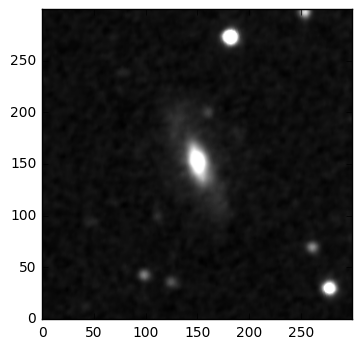

In [26]:
#hdu_list=apfits.open(table['URL'][4].decode("utf-8"))
hdu_list=apfits.open('image.fits')
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

### Alternatively, we can use Aplpy to make an image with coordinates

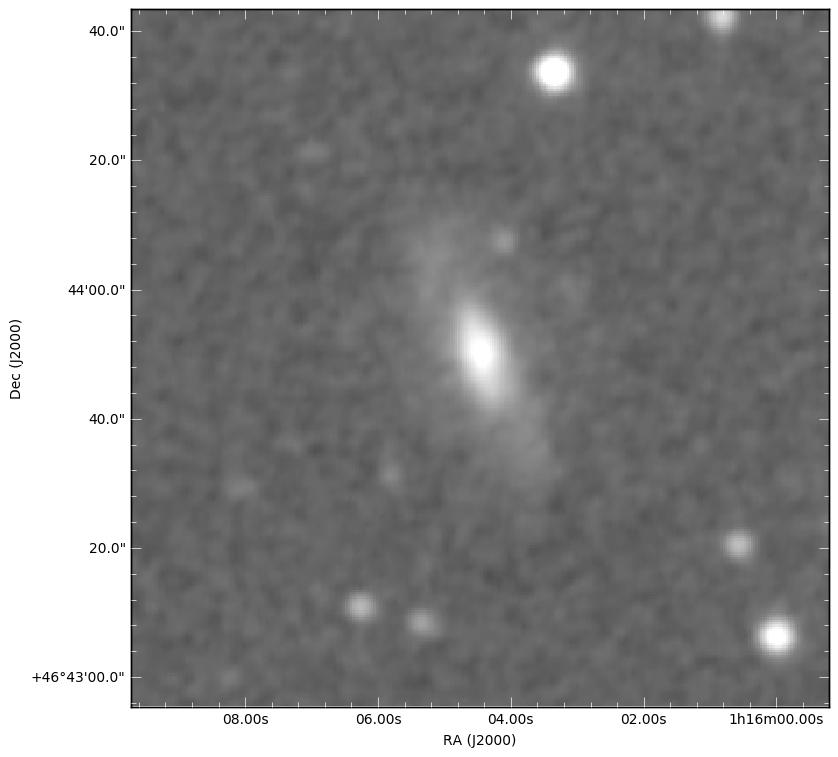

In [27]:
import aplpy
gc = aplpy.FITSFigure(hdu_list)
gc.show_grayscale(stretch='log', vmin=6e-3, vmax=1.4e-1)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [28]:
params['survey']='sdssg'
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)

In [29]:
table=Table.read(io.BytesIO(r.content))
display(Image(url=table['URL'][1].decode("utf-8")))

<a id="tap1"></a>
# 4a. TAP:  Using the Table Access Protocol to find additional information on our sources
TAP is described in more detail in the dedicated [TAP notebook](heasarc_TAP_queries.ipynb).

In this example, we already have a list of 30 sources from above.  <i> Continuing with our hypothetical science example of preparing an observing proposal for these objects, we would now like to find their redshifts, e.g., to calculate exposure times based on being able to significantly detect a 10<sup>39</sup> erg/s source.</i>

First, find out what catalogs HEASARC holds that might have redshifts:

In [30]:

tap_params["query"]="""
    select a.name,b.value
      from metainfo a, metainfo b
      where
         a.type='table' and b.type='table' and
         a.relation='defaultSearchRadius' and
         b.relation='description' and
         a.name=b.name and
         b.value LIKE '%Redshift%' 
      order by name    
      """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
table=Table.read(io.BytesIO(r.content))
table

<Table masked=True length=18>
   name    ...
  object   ...
---------- ...
 abellzcat ...
atlasspecz ...
ccosmphotz ...
     cfa2s ...
  iraspscz ...
 iraszsurv ...
   lcrscat ...
lowzvlqvla ...
planckhzsc ...
   sixdfgs ...
 twodfqsoz ...
twomassrsc ...
    xdeep2 ...
xmmcfrscat ...
xmmcfrsoid ...
 xmmcphotz ...
xmmlssclas ...
      zcat ...

We see that we can query these objects in the CfA Redshift Catalog, 'zcat'.  <i> Since these are galaxies found in close pairs or groups, we expect multiple matches at each location. </i> Let's first start with one object and search within 0.1 degree: 

In [31]:
##  Pick a radius in degrees to search around our input coordinates:
radius=0.1
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":
    """SELECT ra, dec, Radial_Velocity FROM zcat as cat where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{0},{1},{2}))=1
    """.format(aptable[0]['RA'],aptable[0]['DEC'],radius)
    }
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
#r.content
table=Table.read(io.BytesIO(r.content))
table

<Table masked=True length=3>
        ra                dec         radial_velocity
     float64            float64            int32     
------------------ ------------------ ---------------
19.009757430000001 46.730402349999999              -1
19.068407270000002 46.740033570000001            5081
19.086435210000001 46.747227780000003            5188

<a id="tap2"></a>
# 4b. TAP:  Using the TAP to cross-correlate our objects with a catalog

Now to search all of the sources in one go, we need to upload our table and do a 'cross-correlation' of our own table with the 'zcat' table. Above, we had created a VOTableFile object called votablefile. Now we need to hand it to the requests method as upload data and use it in our TAP request.

First, create a "file-like" object that you can hand over:

In [32]:
## Alternatively, write it to a file:
#apvot.writeto(votablefile, "new_votable.xml")
#files={'uplt':open('new_votable.xml', 'rb')}

## In memory only, use an IO stream. 
vot_obj=io.BytesIO()
apvot.writeto(votablefile,vot_obj)
vot_obj.seek(0) # Reset seek to beginning of buffer?
## 'uplt' is what we'll call it (for 'upload table') 
##   in the requests parameters below, or what you will:
files={'uplt':vot_obj}

(This takes a good 20 seconds. If you need to rerun this cell, rerun the one above that defines the upload.  The IO object needs to be reset.) 

In [33]:
## These parameters are defined in the TAP standard.  
##  The string 'uplt' is what we set above as the name
##  of the parameter containing this data, and
##  the string 'mysources' is how we refer to it in 
##  the ADQL query string:
cc_params={
    'lang': 'ADQL', 
    'request': 'doQuery',
    'upload':'mysources,param:uplt'
    }
cc_params["query"]="""
    SELECT cat.ra, cat.dec, Radial_Velocity 
    FROM zcat cat, tap_upload.mysources mt 
    WHERE
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,0.1))=1
    and Radial_Velocity > 0
    ORDER by cat.ra"""
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,stream=True,files=files)
mytable=Table.read(io.BytesIO(r.content))
mytable

<Table masked=True length=39>
        ra                dec         radial_velocity
     float64            float64            int32     
------------------ ------------------ ---------------
19.068407270000002 46.740033570000001            5081
19.086435210000001 46.747227780000003            5188
20.334799289999999 40.487715479999999            5859
125.90444401000001 21.338192790000001            5219
125.90444401000001 21.338192790000001            5364
135.99423805999999        21.90099584            3157
136.00074370999999        21.96791867            3093
141.09150181000001 40.683784680000002            8267
      146.70334308 22.018272169999999            7446
      146.70334308 22.018272169999999            7597
               ...                ...             ...
      237.58156191 20.762982279999999           10926
241.52278516999999        20.78278156            4584
241.52278516999999        20.78278156            4602
241.52278516999999        20.78278156            4798
317.10346952999998 18.202987799999999            4826
317.11477339999999 18.191914189999999            5054
329.24927524999998 6.6551501899999996            7857
      333.82169725 37.299221410000001            5207
      333.84683658 37.282608979999999            5984
333.91491775999998 37.300255790000001            5684

<a id="combo"></a>

# 4c. Another example with TAP table cross-correlation: Combining data from different catalogs
Now we'd like to take the redshift information (above, as a radial velocity) and determine a search radius to use for each galaxy based on its distance, so that we are are searching within a given physical distance. <i>E.g., for our science proposal, we need to check that the redshifts (or radial velocities) of the galaxies that are close on the sky (within 50 kpc physical distances) have similar distances, suggesting these are truly close in 3-dimensions and therefore potentially interacting galaxies.</i>

In [34]:
## The radial_velocity is in km/s, and this is just c*z, so
c=3.0e5 # km/s
redshifts=mytable['radial_velocity'].filled(0.)/c  # Filling masked values with zero
mytable['redshift']=redshifts
from astropy import units
physdist=0.05*units.Mpc # 50 kpc physical distance

## This needs scipy.  
from astropy.cosmology import Planck15
angDdist=Planck15.angular_diameter_distance(mytable['redshift'])
## angDdist is returned from the astropy.cosmology module as a Quantity object, 
##  i.e. a value and a unit.  Arctan is smart enough not to operate on quantities
##  that aren't unitless.  So angDdist.value to just get the value.
angDrad=numpy.arctan(physdist/angDdist)
angDdeg=angDrad*units.deg/units.rad
mytable['angDdeg']=angDdeg
mytable

<Table masked=True length=39>
        ra                dec         ...     redshift         angDdeg     
                                      ...                        deg       
     float64            float64       ...     float64          float64     
------------------ ------------------ ... --------------- -----------------
19.068407270000002 46.740033570000001 ... 0.0169366666667 0.000681042538686
19.086435210000001 46.747227780000003 ... 0.0172933333333 0.000667286051816
20.334799289999999 40.487715479999999 ...         0.01953 0.000592475054061
125.90444401000001 21.338192790000001 ... 0.0173966666667 0.000663405922543
125.90444401000001 21.338192790000001 ...         0.01788  0.00064585248346
135.99423805999999        21.90099584 ... 0.0105233333333  0.00108755212566
136.00074370999999        21.96791867 ...         0.01031   0.0011097660328
141.09150181000001 40.683784680000002 ... 0.0275566666667 0.000424005225996
      146.70334308 22.018272169999999 ...         0.02482 0.000469199967618
               ...                ... ...             ...               ...
      237.58156191 20.762982279999999 ...         0.03642 0.000324263272089
241.52278516999999        20.78278156 ...         0.01528 0.000753359548568
241.52278516999999        20.78278156 ...         0.01534 0.000750467785564
241.52278516999999        20.78278156 ... 0.0159933333333 0.000720384238428
317.10346952999998 18.202987799999999 ... 0.0160866666667 0.000716286081667
317.11477339999999 18.191914189999999 ... 0.0168466666667 0.000684605846616
329.24927524999998 6.6551501899999996 ...         0.02619 0.000445394169968
      333.82169725 37.299221410000001 ... 0.0173566666667  0.00066490242687
      333.84683658 37.282608979999999 ... 0.0199466666667 0.000580392638572
333.91491775999998 37.300255790000001 ... 0.0189466666667 0.000610283341926

In [35]:
## In memory only, use an IO stream. 
vot_obj=io.BytesIO()
print(mytable.columns)
apvot.writeto(apvot.from_table(mytable),vot_obj)
## (Reset the "file-like" object to the beginning.)
vot_obj.seek(0)
## 'uplt' is what we'll call it (for 'upload table') 
##   in the requests parameters below, or what you will:
files={'uplt':vot_obj}


<TableColumns names=('ra','dec','radial_velocity','redshift','angDdeg')>


In [36]:
## These are defined in the TAP standard:
cc_params={
    'lang': 'ADQL', 
    'request': 'doQuery',
    'upload':'mytable,param:uplt'
    }
## This is your ADQL query, where "mytable" here has to 
##  match what you specified in the upload parameter above
cc_params["query"]="""
    SELECT cat.ra, cat.dec, cat.Radial_Velocity 
    FROM zcat cat, tap_upload.mytable mt 
    WHERE
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,mt.angDdeg))=1
    and cat.Radial_Velocity > 0
    ORDER by cat.ra"""
## The name you give here (tab1) matches what's in the cc_params
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,stream=True,files=files)
mytable=Table.read(io.BytesIO(r.content))
mytable

<Table masked=True length=49>
        ra                dec         radial_velocity
     float64            float64            int32     
------------------ ------------------ ---------------
19.068407270000002 46.740033570000001            5081
19.086435210000001 46.747227780000003            5188
20.334799289999999 40.487715479999999            5859
125.90444401000001 21.338192790000001            5219
125.90444401000001 21.338192790000001            5219
125.90444401000001 21.338192790000001            5364
125.90444401000001 21.338192790000001            5364
135.99423805999999        21.90099584            3157
136.00074370999999        21.96791867            3093
141.09150181000001 40.683784680000002            8267
               ...                ...             ...
241.52278516999999        20.78278156            4602
241.52278516999999        20.78278156            4798
241.52278516999999        20.78278156            4798
241.52278516999999        20.78278156            4798
317.10346952999998 18.202987799999999            4826
317.11477339999999 18.191914189999999            5054
329.24927524999998 6.6551501899999996            7857
      333.82169725 37.299221410000001            5207
      333.84683658 37.282608979999999            5984
333.91491775999998 37.300255790000001            5684

<a id="ssa"></a>
# 6. SSA:  Using the Simple Spectral Access protocol to retrieve spectra.

See also the [notebook](heasarc_Spectral_Access.ipynb) specific to the Simple Spectral Access __[Protocol](http://www.ivoa.net/documents/SSA/)__.

<i>Returning to our science example, suppose that we have analyzed the available Chandra image for the three matches above and discovered that one of these galaxies appears to have a potential ultraluminous X-ray source (ULX)! Now, we want to charatcterize the spectrum for this source. Therefore we will ask for a large exposure time and need to justify this by showing the spectrum of a prototypical ULX, M82 X-1. </i>


In [10]:
import astropy.coordinates as coord
m82=coord.SkyCoord.from_name("m82")
pos='{},{}'.format(m82.ra.deg,m82.dec.deg)
params = {'table': 'chanmaster',"POS":pos,"SIZE":".01", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
spec_table = Table.read(io.BytesIO(r.content))
spec_table

<Table masked=True length=3>
obsid   status  ...    SSA_format   
                ...                 
object  object  ...      object     
------ -------- ... ----------------
 17860 archived ... application/fits
 19791 archived ... application/fits
 19792 archived ... application/fits

In [11]:
## Get the first spectrum (which has a long-ish exposure.)
import astropy.io.fits as fits
hdu_list=fits.open(spec_table[0]['SSA_reference'].decode()) # Byte format, so just decode() to string
#hdu_list.info()
table = Table(hdu_list[1].data)
table


<Table length=12>
SPEC_NUM  TG_M ...          BIN_LO [8192]              BIN_HI [8192]     
 int16   int16 ...             float64                    float64        
-------- ----- ... ------------------------------- ----------------------
       1    -3 ... 7.15916666667 .. 0.333333333333 7.16 .. 0.334166666667
       2    -2 ...                 10.73875 .. 0.5       10.74 .. 0.50125
       3    -1 ...                  21.4775 .. 1.0        21.48 .. 1.0025
       4     1 ...                  21.4775 .. 1.0        21.48 .. 1.0025
       5     2 ...                 10.73875 .. 0.5       10.74 .. 0.50125
       6     3 ... 7.15916666667 .. 0.333333333333 7.16 .. 0.334166666667
       7    -3 ...        13.985 .. 0.333333333333 13.9866666667 .. 0.335
       8    -2 ...                  20.9775 .. 0.5        20.98 .. 0.5025
       9    -1 ...                   41.955 .. 1.0         41.96 .. 1.005
      10     1 ...                   41.955 .. 1.0         41.96 .. 1.005
      11     2 ...                  20.9775 .. 0.5        20.98 .. 0.5025
      12     3 ...        13.985 .. 0.333333333333 13.9866666667 .. 0.335

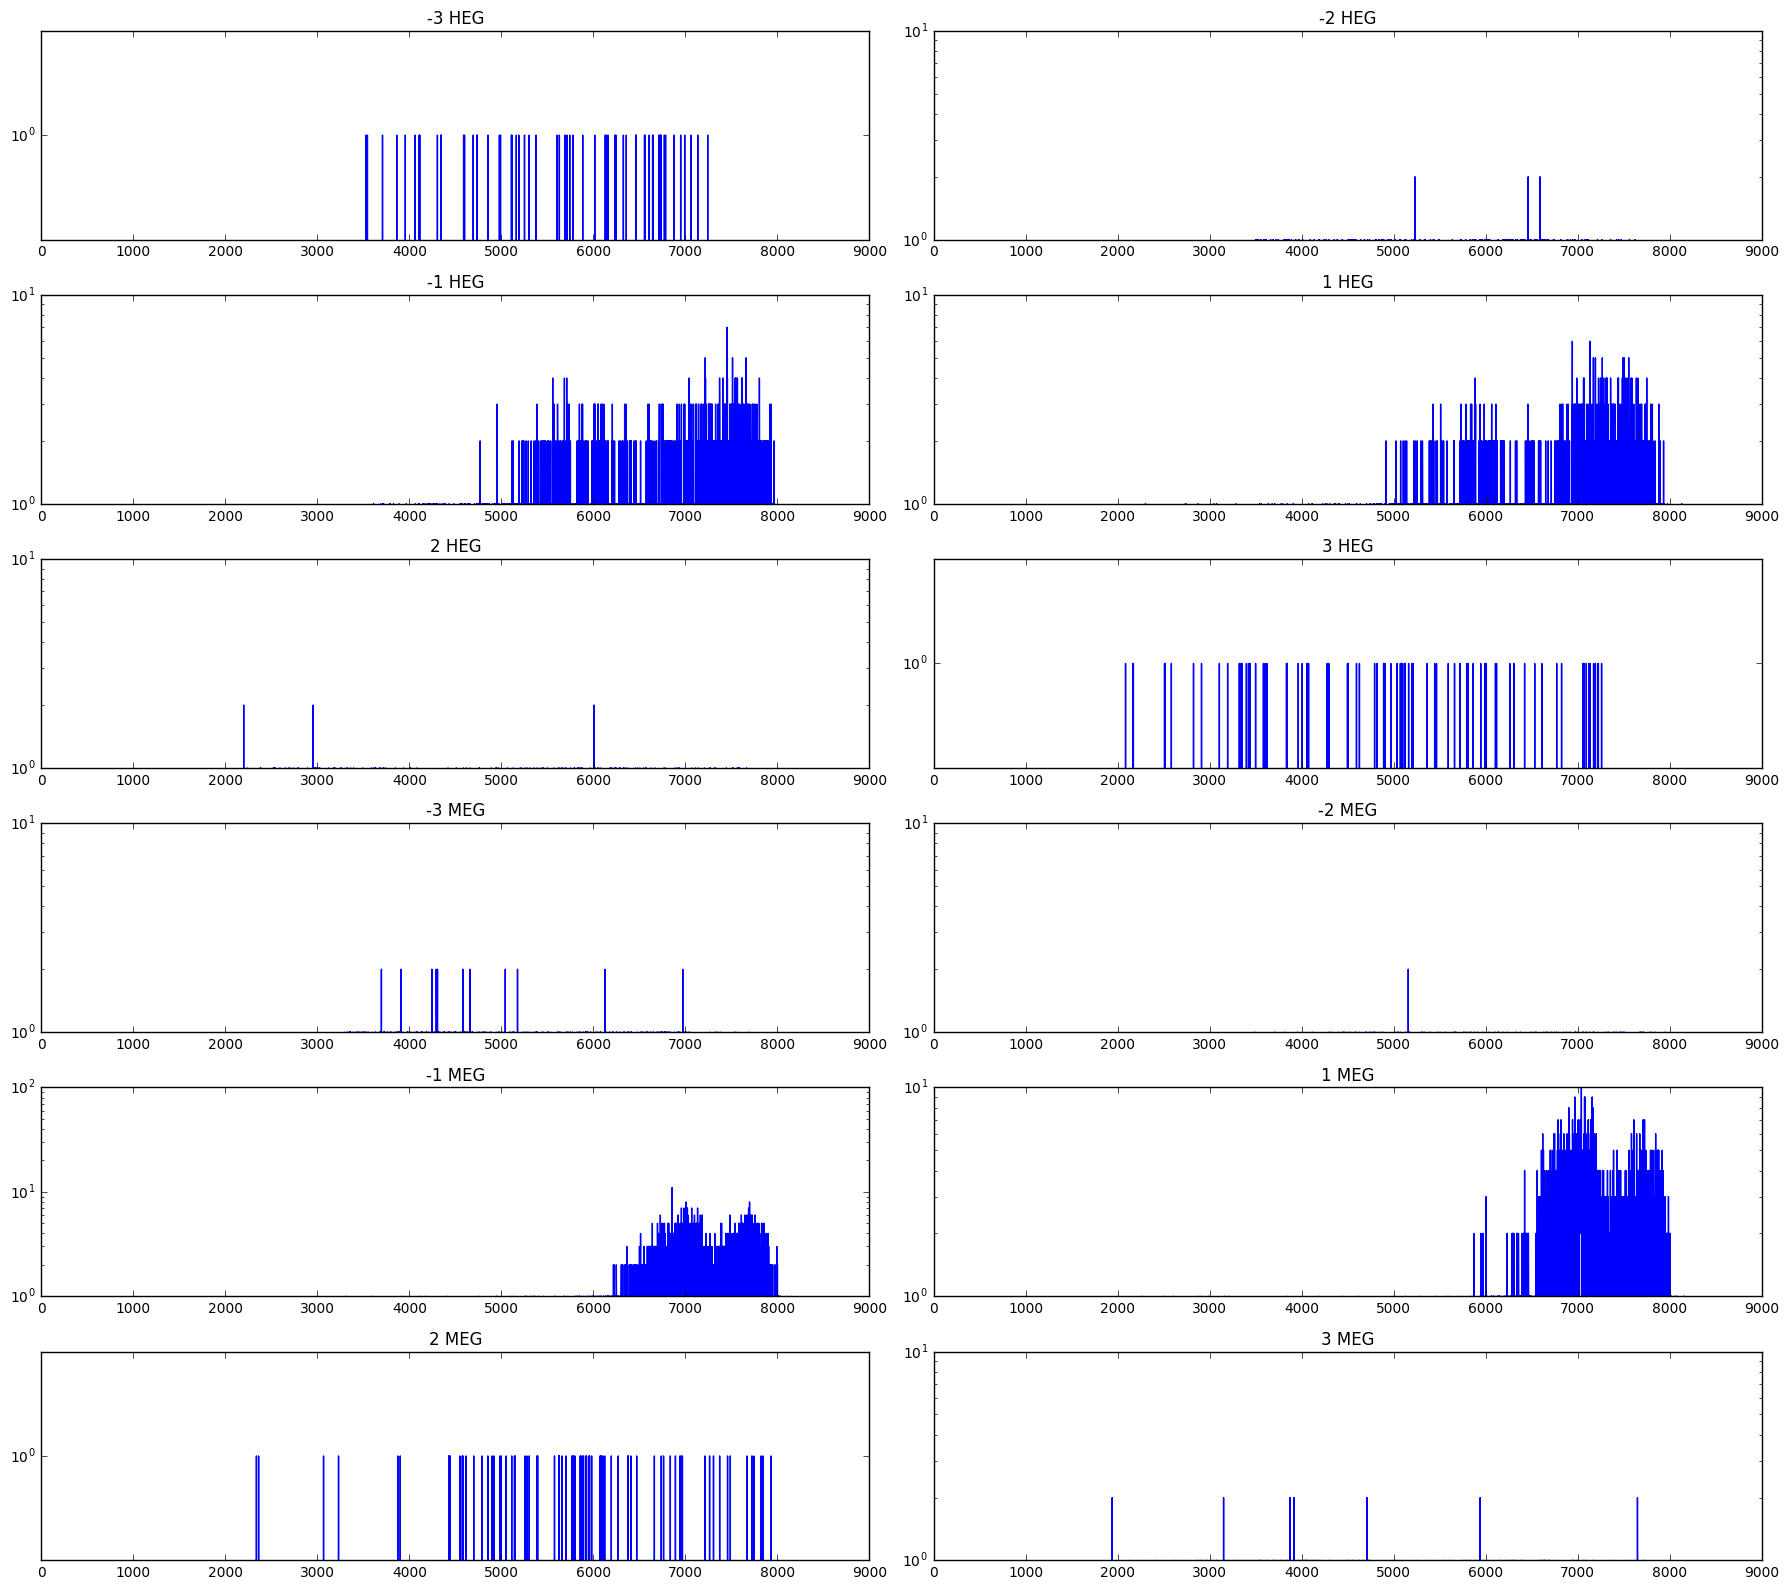

In [12]:
for i in range(len(table)):
    matplotlib.rcParams['figure.figsize'] = (18, 16)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( table['CHANNEL'][i],table['COUNTS'][i])
    ax.set_yscale('log')
    if table['TG_PART'][i] == 1:
        instr='HEG'
    if table['TG_PART'][i] == 2:
        instr='MEG'
    if table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title(str(table['TG_M'][i])+' '+instr)
    plt.tight_layout()
    

Note: The 12 plots here show all the different HEG and MEG components (+/- 3, +/- 2, and +/- 1 for each grating) for the grating data, as titled. In practice, you might want to download the fits file and use a different analysis and plotting tool to create an energy spectrum plot using SHERPA or XSPEC, etc. 

You can download the file directly using requests:

In [13]:
## Because urllib is hard to make Python 2/3 compatible, just use requests:
r=requests.get(spec_table[0]['SSA_reference'].decode(), stream=True)
with open('my_M82_spectrum.fits','wb') as f:
    f.write(r.content)